In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import string
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import accuracy_score

import torch
from transformers import BertTokenizer
import os
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Parameters for BERT model and tokenization
bert_path = "bert-base-uncased"  # Use the Hugging Face model

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_path)

def get_df(file):
    return pd.read_csv(file,sep = '\t')

train_df = get_df('train_posts.txt')
test_df = get_df('test_posts.txt')

def return_first_image(row):
    return row['imageId(s)'].split(',')[0].strip()

tqdm.pandas()
train_df['first_image_id'] = train_df.progress_apply (lambda row: return_first_image(row),axis=1)
test_df['first_image_id'] = test_df.progress_apply (lambda row: return_first_image(row),axis=1)

from os import listdir

images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train_folder = [i.split('.')[0].strip() for i in listdir('images_train/')]
images_train_not_available = set(images_train_dataset)-set(images_train_folder)
images_train_not_available

images_test_dataset = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]
images_test_folder = [i.split('.')[0].strip() for i in listdir('images_test/')]
images_test_not_available = set(images_test_dataset)-set(images_test_folder)
images_test_not_available

train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]
test_df = test_df[~test_df['first_image_id'].isin(images_test_not_available)]

train_text = train_df['tweetText'].tolist()
test_text = test_df['tweetText'].tolist()

train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i.split(',')[0].strip() for i in test_df['imageId(s)'].tolist()]

trainY = train_df['label'].tolist()
trainY = [1 if i=='real' else 0 for i in trainY]

testY = test_df['label'].tolist()
testY = [1 if i=='real' else 0 for i in testY]

c:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 3755/3755 [00:00<00:00, 51395.75it/s]


# Text part

#ALBERT-base


In [5]:
import numpy as np
from transformers import AlbertTokenizer
from tqdm import tqdm  # Import tqdm for progress tracking
import torch

class PaddingInputExample:
    """Fake example so the num input examples is a multiple of the batch size."""
    pass  # No need for methods or properties; just a marker class

class InputExample:
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs an InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence.
            text_b: (Optional) string. The untokenized text of the second sequence.
            label: (Optional) string. The label of the example.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer():
    """Instantiate the ALBERT tokenizer."""
    return AlbertTokenizer.from_pretrained('albert-base-v2')

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""
    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)

    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)

    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""
    input_ids, input_masks, segment_ids, labels = [], [], [], []

    for example in tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)

    return (
        torch.tensor(input_ids),          # Use torch tensors
        torch.tensor(input_masks),        # Use torch tensors
        torch.tensor(segment_ids),        # Use torch tensors
        torch.tensor(labels).reshape(-1, 1)  # Use torch tensors
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    input_examples = []
    for text, label in zip(texts, labels):
        input_examples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return input_examples

# Instantiate the tokenizer
tokenizer = create_tokenizer()

# Convert data to InputExample format
# Assuming train_text and trainY, test_text and testY are already defined
train_examples = convert_text_to_examples(train_text, trainY)
test_examples = convert_text_to_examples(test_text, testY)

# Convert to features
train_input_ids, train_input_masks, train_segment_ids, trainY = convert_examples_to_features(tokenizer, train_examples, max_seq_length=256)
test_input_ids, test_input_masks, test_segment_ids, testY = convert_examples_to_features(tokenizer, test_examples, max_seq_length=256)

# Now you can proceed to use `train_input_ids`, `train_input_masks`, `train_segment_ids`, and `trainY`
# for training your model in PyTorch


Converting examples to features: 100%|██████████| 1923/1923 [00:01<00:00, 1149.78it/s]


# Image Part

In [6]:
train_imagesX = np.load('train_imagesX.npy')
test_imagesX = np.load('test_imagesX.npy')

In [7]:
train_imagesX = np.rollaxis(train_imagesX, 3, 1)
test_imagesX = np.rollaxis(test_imagesX,3,1)

# Alternatively, using from_numpy which preserves the original data type
train_imagesX = torch.from_numpy(train_imagesX).float()
test_imagesX  = torch.from_numpy(test_imagesX).float()

# The Model

In [12]:
from torchvision import models
# Define the main NewsModel
class image_feature_extract(nn.Module):
    def __init__(self):
        super(image_feature_extract, self).__init__()
       
        # Image model with VGG-19 feature extractor
        self.vgg_base = models.vgg19(pretrained=True)
        self.vgg_base.classifier = nn.Identity()  # Remove classifier for feature extraction
        for param in self.vgg_base.parameters():
            param.requires_grad = False  # Freeze VGG base layers
    
    def forward(self,image):

        # VGG-19 forward pass
        image_features = self.vgg_base(image)
        image_flatten = image_features.view(image_features.size(0), -1)  # Flatten for fully connected layers
        return image_flatten

In [ ]:
import torch
from tqdm import tqdm  # Import tqdm for progress tracking

# Initialize feature extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19_layer = image_feature_extract().to(device)  # Ensure params are passed to the class

# # Move input data to GPU
# train_imagesX = train_imagesX.to(device)

# Move input data to GPU test data
train_imagesX = test_imagesX.to(device)

# Process in batches with mixed precision
batch_size = 10  # Adjust based on VRAM usage
features = []

with torch.no_grad():  # Disable gradient tracking
    # Use tqdm to create a progress bar for the batch processing loop
    for i in tqdm(range(0, len(train_imagesX), batch_size), desc="Processing images"):
        imagesX = train_imagesX[i:i + batch_size]

        batch_features = vgg19_layer(imagesX)
        features.append(batch_features.cpu())  # Move to CPU to free up GPU memory

# Concatenate all batches for final output
features = torch.cat(features)
torch.save(features, "image_features_test.pt")
print(features.shape)


c:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Processing images: 100%|██████████| 193/193 [00:11<00:00, 17.01it/s]


torch.Size([1923, 25088])


In [8]:
import torch.nn as nn
from torchvision import models
# Define the main NewsModel
class NewsModel(nn.Module):
    def __init__(self, params):
        super(NewsModel, self).__init__()
        
        # # Initialize the BertLayer
        # self.bert_layer = AlbertLayer(albert_path="albert-base-v1", 
        #                             n_fine_tune_layers=params['n_fine_tune_layers'])
        
        # # Text model layers (if additional hidden layers are specified)
        text_hidden_layers = []
        input_size = 768 #self.bert_layer.output_size
        for _ in range(params['text_no_hidden_layer']):
            text_hidden_layers.append(nn.Linear(input_size, params['text_hidden_neurons']))
            text_hidden_layers.append(nn.ReLU())
            text_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['text_hidden_neurons']
        self.text_hidden_layers = nn.Sequential(*text_hidden_layers)
        
        self.text_repr = nn.Linear(input_size, params['repr_size'])
        
        # # Image model with MobileNet feature extractor
        # self.mobilenet_base = models.mobilenet_v2(pretrained=True)  # Use MobileNetV2
        # self.mobilenet_base.classifier = nn.Identity()  # Remove classifier for feature extraction
        # for param in self.mobilenet_base.parameters():
        #     param.requires_grad = False  # Freeze MobileNet base layers
        
        # Additional hidden layers for image model (if specified)
        vis_hidden_layers = []
        input_size = 512*7*7  # Flattened output from MobileNetV2
        for _ in range(params['vis_no_hidden_layer']):
            vis_hidden_layers.append(nn.Linear(input_size, params['vis_hidden_neurons']))
            vis_hidden_layers.append(nn.ReLU())
            vis_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['vis_hidden_neurons']
        self.vis_hidden_layers = nn.Sequential(*vis_hidden_layers)

        self.visual_repr = nn.Linear(input_size, params['repr_size'])
        
        # Final combined classifier
        combined_size = 2 * params['repr_size']
        final_hidden_layers = []
        for _ in range(params['final_no_hidden_layer']):
            final_hidden_layers.append(nn.Linear(combined_size, params['final_hidden_neurons']))
            final_hidden_layers.append(nn.ReLU())
            final_hidden_layers.append(nn.Dropout(params['dropout']))
            combined_size = params['final_hidden_neurons']
            
        self.final_hidden_layers = nn.Sequential(*final_hidden_layers)

        self.classifier = nn.Linear(combined_size, 1)  # Binary classification
    
    def forward(self,features, image_features):
        # BERT forward pass
        #text_output = self.bert_layer(input_ids, attention_mask, token_type_ids)
        
        text_output = self.text_hidden_layers(features)
        text_repr = self.text_repr(text_output)
        
        # VGG-19 forward pass
        image_features = image_features
        #image_flatten = image_features.view(image_features.size(0), -1)  # Flatten for fully connected layers
        #image_output = self.vis_hidden_layers(image_flatten)
        image_output = self.vis_hidden_layers(image_features )
        visual_repr = self.visual_repr(image_output)
        
        # Concatenate text and visual representations
        combined_repr = torch.cat((text_repr, visual_repr), dim=1)
        combined_output = self.final_hidden_layers(combined_repr)
        
        # Final classifier layer
        prediction = torch.sigmoid(self.classifier(combined_output))
        
        return prediction

In [9]:
params = {

    'text_no_hidden_layer':1,
    'text_hidden_neurons':768,   #'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':1,
    'vis_hidden_neurons':2742,   #'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':35,
    'optimizer':['adam'],
}

In [9]:
import torch

# Check if CUDA is available
is_cuda_available = torch.cuda.is_available()
print(f"Is CUDA available? {is_cuda_available}")

# If CUDA is available, get the current device
if is_cuda_available:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"Current GPU device: {device_name}")
else:
    print("Using CPU")


Is CUDA available? True
Current GPU device: NVIDIA GeForce RTX 3060 Laptop GPU


In [11]:
params = {

    'text_no_hidden_layer':1,
    'text_hidden_neurons':768,   #'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':7,
    'vis_hidden_neurons':2742,   #'vis_hidden_neurons':2742,
    'final_no_hidden_layer':7,
    'final_hidden_neurons':35,
    'optimizer':['adam'],
}

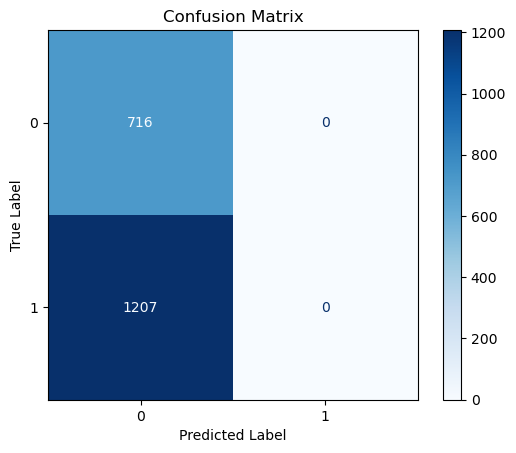

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [17]:
params = {

    'text_no_hidden_layer':2,
    'text_hidden_neurons':768,   #'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':2,
    'vis_hidden_neurons':2742,   #'vis_hidden_neurons':2742,
    'final_no_hidden_layer':7,
    'final_hidden_neurons':35,
    'optimizer':['adam'],
}

C:\Users\swaru\AppData\Local\Temp\ipykernel_15156\148919776.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load("albert_features.pt")
C:\Users\swaru\Ap

Features shape: torch.Size([14258, 768])
Image features shape: torch.Size([14258, 25088])
Labels shape: torch.Size([14258, 1])
Epoch: 1/20, Loss: 0.5751, Val Loss: 0.2791
Epoch: 2/20, Loss: 0.2348, Val Loss: 0.2614
Epoch: 3/20, Loss: 0.2310, Val Loss: 0.2379
Epoch: 4/20, Loss: 0.1944, Val Loss: 0.1985
Epoch: 5/20, Loss: 0.1340, Val Loss: 0.1655
Epoch: 6/20, Loss: 0.0808, Val Loss: 0.1136
Epoch: 7/20, Loss: 0.1000, Val Loss: 0.0852
Epoch: 8/20, Loss: 0.2319, Val Loss: 0.0609
Epoch: 9/20, Loss: 0.0828, Val Loss: 0.0560
Epoch: 10/20, Loss: 0.0887, Val Loss: 0.0640
Epoch: 11/20, Loss: 0.0430, Val Loss: 0.0716
Epoch: 12/20, Loss: 0.0369, Val Loss: 0.0907
Epoch: 13/20, Loss: 0.1956, Val Loss: 0.1614
Epoch: 14/20, Loss: 0.0317, Val Loss: 0.1010
Epoch: 15/20, Loss: 0.0303, Val Loss: 0.0844
Epoch: 16/20, Loss: 0.0655, Val Loss: 0.0627
Epoch: 17/20, Loss: 0.0817, Val Loss: 0.0841
Epoch: 18/20, Loss: 0.0539, Val Loss: 0.0797
Epoch: 19/20, Loss: 0.0527, Val Loss: 0.0951
Epoch: 20/20, Loss: 0.0208,

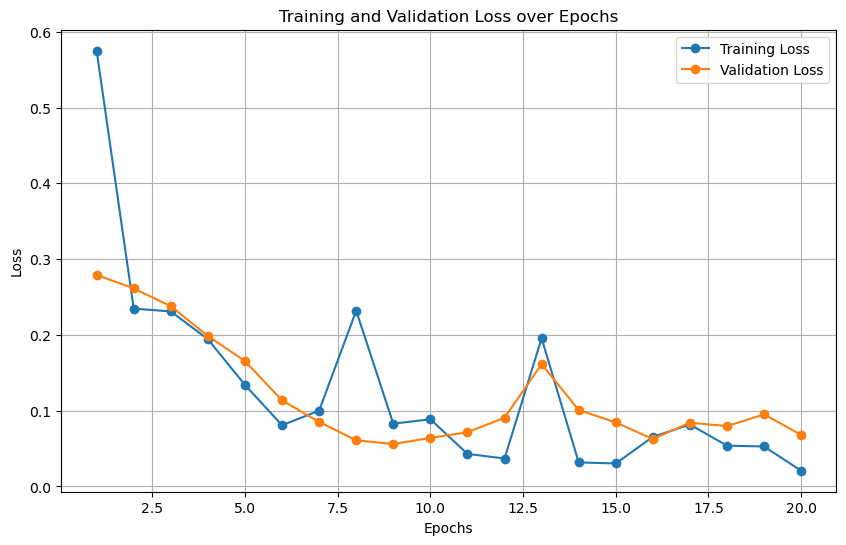

In [23]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

# Load saved features
features = torch.load("albert_features.pt")
image_features = torch.load("image_features.pt")
labels = trainY

# Check the sizes of the loaded tensors
print("Features shape:", features.shape)
print("Image features shape:", image_features.shape)
print("Labels shape:", labels.shape)

# Create a dataset
dataset = TensorDataset(features, image_features, labels)

# Define the split ratio for training and validation
train_ratio = 0.7
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Create the model
model_adam = NewsModel(params).to(current_device)

# Set the learning rate and optimizer
fixed_lr = 0.001  # Set the desired learning rate
optimizer = optim.Adam(model_adam.parameters(), lr=fixed_lr,weight_decay=1e-5)
criterion = nn.BCELoss()
train_losses = []
val_losses = []
# Training loop
num_epochs = 20 # Set the desired number of epochs
for epoch in range(num_epochs):
    model_adam.train()  # Set the model to training mode
    for batch_features, batch_image_features, batch_labels in train_loader:
        # Move inputs to device
        device = next(model_adam.parameters()).device
        batch_features, batch_image_features, batch_labels = (
            batch_features.to(device),
            batch_image_features.to(device),
            batch_labels.float().to(device)
        )

        # Forward pass
        outputs = model_adam(batch_features, batch_image_features)
        outputs = outputs.unsqueeze(1)
        loss = criterion(outputs.squeeze(), batch_labels.squeeze())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model_adam.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No gradient tracking for validation
        for val_features, val_image_features, val_labels in val_loader:
            val_features, val_image_features, val_labels = (
                val_features.to(device),
                val_image_features.to(device),
                val_labels.float().to(device)
            )

            # Forward pass
            val_outputs = model_adam(val_features, val_image_features)
            val_outputs = val_outputs.unsqueeze(1)
            val_loss += criterion(val_outputs.squeeze(), val_labels.squeeze()).item()

    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader)
    
    # Print results for the current epoch
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}")
    train_losses.append(loss.item())
    val_losses.append(avg_val_loss)

#After the training loop, you can save the model or perform evaluation as needed

# Optionally, visualize the losses later
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), np.array(train_losses), label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1),np.array(val_losses), label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [21]:
#torch.save(model_adam, 'model_complete.pth')
# Load the entire model
model = torch.load('model_complete.pth')

C:\Users\swaru\AppData\Local\Temp\ipykernel_26820\1937569720.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_complete.pth')


In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load saved features
test_features = torch.load("albert_features_test.pt")
test_image_features = torch.load("image_features_test.pt")
test_labels = testY  # Assuming testY is defined elsewhere

# Create a test dataset and dataloader
test_dataset = TensorDataset(test_features, test_image_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#model_adam=model
# Set the model to evaluation mode
model_adam.eval()
test_loss = 0.0
criterion = nn.BCELoss()  # Using the same loss function as in training

# Initialize metrics
total_samples = 0

# Initialize accumulators for overall metrics
all_true_labels = []
all_predicted_labels = []
test_loss = 0.0  # Resetting test_loss to use for averaging later

with torch.no_grad():  # Disable gradient calculations for testing
    for features, image_features, labels in test_loader:
        # Move inputs to device
        features, image_features, labels = (
            features.to(device),
            image_features.to(device),
            labels.float().to(device)  # Ensure labels are floats for BCELoss
        )

        # Forward pass
        outputs = model_adam(features, image_features)
        outputs = outputs.unsqueeze(1)  # Adjusting dimensions if needed
        
        # Calculate the batch test loss
        loss = criterion(outputs.squeeze(), labels.squeeze())
        test_loss += loss.item()  # Accumulate loss
        total_samples += labels.size(0)  # Count total samples

        # Convert probabilities to binary predictions (assuming output is in [0, 1])
        predicted_labels = (outputs.squeeze().cpu().numpy() > 0.5).astype(int)  # Apply threshold
        true_labels = labels.squeeze().cpu().numpy()  # Use correct variable name

        # Store the true and predicted labels for overall metrics
        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

# Convert to numpy arrays for metric calculations
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate overall metrics
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='binary')

# Calculate the average test loss
avg_test_loss = test_loss / len(test_loader)  # This gives you the average loss per batch

# Print overall metrics
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1 Score: {f1:.4f}")


C:\Users\swaru\AppData\Local\Temp\ipykernel_15156\2724261849.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_features = torch.load("albert_features_test.pt")
C:\Use

Average Test Loss: 0.5807
Overall Accuracy: 0.8684
Overall Precision: 0.8322
Overall Recall: 0.9901
Overall F1 Score: 0.9043


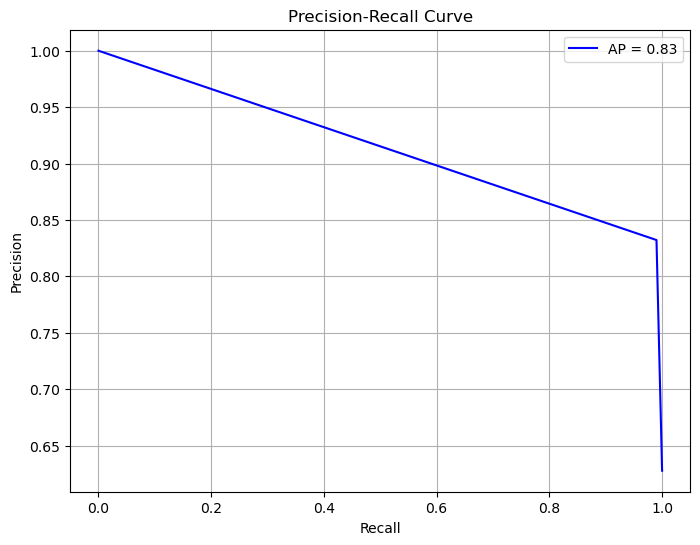

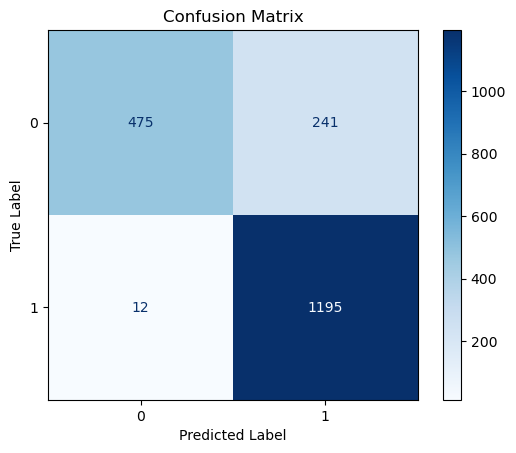

In [25]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(all_true_labels, all_predicted_labels)

# Calculate Average Precision (AP) score
average_precision = average_precision_score(all_true_labels, all_predicted_labels)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {average_precision:.2f}', color='b')

# Add plot details
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


